In [1]:
import cubo
import xarray as xr
import matplotlib

# 1. Get data

In [3]:
da = cubo.create(
    lat=12.8681,
    lon=105.4509,
    collection="landsat-c2-l2",
    bands=["blue","green","red", "nir08"],
    start_date="2015-01-01", # start project date 
    end_date="2044-06-30", # end date
    edge_size=2500,
    resolution=30,
    query={
        "eo:cloud_cover": {"lt": 9},
        "platform": {"eq": "landsat-8"}
    }
)

# crs 32648
da



/home/federico/.pyenv/versions/3.8.8/envs/pg8/lib/python3.8/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'landsat-c2-l2' (time: 102, band: 4, y: 2500, x: 2500)>
dask.array<fetch_raster_window, shape=(102, 4, 2500, 2500), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/30)
  * time                         (time) datetime64[ns] 2015-01-08T03:13:29.98...
    id                           (time) <U31 'LC08_L2SP_125051_20150108_02_T1...
  * band                         (band) <U5 'blue' 'green' 'red' 'nir08'
  * x                            (x) float64 5.114e+05 5.114e+05 ... 5.864e+05
  * y                            (y) float64 1.46e+06 1.46e+06 ... 1.385e+06
    landsat:correction           <U4 'L2SP'
    ...                           ...
    title                        (band) <U22 'Blue Band' ... 'Near Infrared B...
    raster:bands                 object {'scale': 2.75e-05, 'nodata': 0, 'off...
    common_name                  (band) <U5 'blue' 'green' 'red' 'nir08'
    center_wavelength            (band) float64 0.48 0.56 0.65 0.87
    full_width_half_max          (band) float64 0.06 0.06 0.04 0.03
    epsg                         <U10 'EPSG:32648'
Attributes:
    collection:           landsat-c2-l2
    stac:                 https://planetarycomputer.microsoft.com/api/stac/v1
    epsg:                 EPSG:32648
    resolution:           30
    edge_size:            2500
    central_lat:          12.8681
    central_lon:          105.4509
    central_y:            1422592.3438612917
    central_x:            548922.3612959113
    time_coverage_start:  2015-01-01
    time_coverage_end:    2044-06-30

# 2. Remove captures with NAN in ROI, and save rasters

In [7]:
"""
da = (da * 0.0000275) - 0.2
ds = da.to_dataset()

"""
import geopandas as gpd
import rioxarray
import numpy 

gpd = gpd.read_file('./data/TUMRING/TUMRING.geojson')
gpd = gpd.to_crs("32648")
da = da.rio.write_crs("32648")


ds = da.to_dataset()

path_data = 'data/TUMRING/satellite_images/'
dates_extracted = []
days_total = len(da['time'])

for day_idx in range(len(da['time'])):
    print(str(day_idx) + "   "+ str(da['time'][day_idx].data))
    ds = da.to_dataset()
    ds = ds.isel(time=(day_idx))
    ds = ds.squeeze()  # remove dimensions with size 1
    ds = ds.rio.write_crs("32648")

    try:
        if not numpy.isnan(numpy.min(ds['landsat-c2-l2'].to_numpy())):
            ds = ds.rio.clip(gpd.geometry, all_touched=True)
            ds['landsat-c2-l2'].rio.to_raster(path_data + str(da['time'][day_idx].data)[:10] + '.tif')
            dates_extracted.append(str(da['time'][day_idx].data)[:10])
    except:
        pass
print(f"extracted and saved {len(dates_extracted)} out of {len(da['time'])} captures")

0   2015-01-08T03:13:29.982468000
1   2015-01-08T03:13:53.894685000
2   2015-01-15T03:19:39.382766000
3   2015-01-24T03:13:23.531457000
4   2015-01-24T03:13:47.430966000
5   2015-01-31T03:19:34.830432000
6   2015-02-09T03:13:19.704636000
7   2015-02-09T03:13:43.608381000
8   2015-02-16T03:19:26.145922000
9   2015-03-13T03:13:02.707654000
10   2015-03-29T03:12:54.851466000
11   2015-03-29T03:13:18.759447000
12   2015-04-14T03:12:49.874425000
13   2015-04-14T03:13:13.778170000
14   2015-04-21T03:18:59.524650000
15   2015-06-08T03:18:50.724091000
16   2015-10-30T03:19:44.058978000
17   2015-12-01T03:19:46.574861000
18   2016-01-02T03:19:43.637647000
19   2016-01-11T03:13:55.076387000
20   2016-02-19T03:19:30.848775000
21   2016-02-28T03:13:20.550865000
22   2016-02-28T03:13:44.454611000
23   2016-03-06T03:19:30.619047000
24   2016-03-31T03:13:06.338286000
25   2016-03-31T03:13:30.242032000
26   2016-04-07T03:19:15.543638000
27   2016-11-10T03:13:46.324285000
28   2017-01-04T03:19:49.83393

# 3. Compute average NDVI for each capture

In [16]:
import glob
import numpy as np
import rioxarray
import os

stats_NDVI = []
stats_LAI = []
stats_EVI = []

dates = []
for file in sorted(glob.glob('data/TUMRING/satellite_images/*')):
    print(file)
    
    # open raster and get bands
    da = rioxarray.open_rasterio(file, masked=True)
    B = da.sel(band=[1]).to_numpy()
    R = da.sel(band=[3]).to_numpy()
    NIR = da.sel(band=[4]).to_numpy()
    
    # compute indices
    EVI = 2.5 * ((NIR - R) / (NIR + 6 * R - 7.5 * B + 1))
    LAI = (3.618*EVI - 0.118) 
    NDVI = ( NIR - R ) / ( NIR + R ) 


    EVI = EVI[~np.isnan(EVI)]
    NDVI = NDVI[~np.isnan(NDVI)]
    LAI = LAI[~np.isnan(LAI)]

    if LAI.mean() != np.inf and NDVI.mean() != np.inf:
        stats_LAI.append({
        'min': LAI.min(),
        'mean': LAI.mean(),
        'median': np.median(LAI),
        'max': LAI.max()})
        
        stats_NDVI.append({
    'min': NDVI.min(),
    'mean': NDVI.mean(),
    'median': np.median(NDVI),
    'max': NDVI.max()})
        
   # print(os.path.basename(file).split('.')[0])
        dates.append(os.path.basename(file).split('.')[0])


data/TUMRING/satellite_images/2015-01-15.tif
data/TUMRING/satellite_images/2015-01-31.tif
data/TUMRING/satellite_images/2015-02-16.tif
data/TUMRING/satellite_images/2015-04-21.tif
data/TUMRING/satellite_images/2015-06-08.tif
data/TUMRING/satellite_images/2016-01-02.tif


/tmp/ipykernel_110690/951576558.py:21: RuntimeWarning: divide by zero encountered in divide
  EVI = 2.5 * ((NIR - R) / (NIR + 6 * R - 7.5 * B + 1))


data/TUMRING/satellite_images/2016-02-19.tif
data/TUMRING/satellite_images/2016-04-07.tif
data/TUMRING/satellite_images/2017-01-04.tif


/tmp/ipykernel_110690/951576558.py:21: RuntimeWarning: divide by zero encountered in divide
  EVI = 2.5 * ((NIR - R) / (NIR + 6 * R - 7.5 * B + 1))


data/TUMRING/satellite_images/2018-02-08.tif
data/TUMRING/satellite_images/2018-03-12.tif
data/TUMRING/satellite_images/2018-12-25.tif


/tmp/ipykernel_110690/951576558.py:21: RuntimeWarning: divide by zero encountered in divide
  EVI = 2.5 * ((NIR - R) / (NIR + 6 * R - 7.5 * B + 1))


data/TUMRING/satellite_images/2019-01-26.tif
data/TUMRING/satellite_images/2019-02-11.tif
data/TUMRING/satellite_images/2019-02-27.tif
data/TUMRING/satellite_images/2019-10-25.tif
data/TUMRING/satellite_images/2019-11-26.tif
data/TUMRING/satellite_images/2021-01-15.tif
data/TUMRING/satellite_images/2022-04-08.tif
data/TUMRING/satellite_images/2022-12-20.tif
data/TUMRING/satellite_images/2023-03-10.tif


In [17]:
import pandas as pd

means_NDVI = [stat['mean'] for stat in stats_NDVI]
means_LAI = [stat['mean'] for stat in stats_LAI]

d = {'NDVI': means_NDVI, "LAI": means_LAI}
df = pd.DataFrame(data=d)
# ambient air temperature
# the simple moving average 
df['NDVI_SMA_15'] = df.NDVI.rolling(15, min_periods=1, center=True).mean()
df['LAI_SMA_15'] = df.LAI.rolling(15, min_periods=1, center=True).mean()



# Add regression line

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import linear_model

data_time = np.asarray(dates)
data_count = np.asarray(means_NDVI)

dfr = pd.DataFrame({'time': data_time, 'count': data_count})
dfr.time = pd.to_datetime(dfr.time)

regr = linear_model.LinearRegression()
regr.fit(dfr.time.values.reshape(-1, 1), dfr['count'].values.reshape(-1, 1))

# Make predictions using the testing set
y_pred = regr.predict(dfr.time.values.astype(float).reshape(-1, 1))

df['REG_NDVI'] = y_pred
print("NDVI coefficient:")
print(regr.coef_)


data_time = np.asarray(dates)
data_count = np.asarray(means_LAI)

dfr = pd.DataFrame({'time': data_time, 'count': data_count})
dfr.time = pd.to_datetime(dfr.time)

regr = linear_model.LinearRegression()
regr.fit(dfr.time.values.reshape(-1, 1), dfr['count'].values.reshape(-1, 1))
print("LAI coefficient:")
print(regr.coef_)
# Make predictions using the testing set
y_pred = regr.predict(dfr.time.values.astype(float).reshape(-1, 1))

df['REG_LAI'] = y_pred


NDVI coefficient:
[[-9.65828718e-20]]
LAI coefficient:
[[-9.95002647e-18]]


# Plot

/tmp/ipykernel_110690/1805376702.py:12: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  df[['LAI','LAI_SMA_15', 'REG_LAI']].plot(subplots=True, ax=target1, legend=True, sharex=True, sharey=False, color=colors)
/tmp/ipykernel_110690/1805376702.py:16: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  df[['NDVI','NDVI_SMA_15', 'REG_NDVI']].plot(subplots=True, ax=target2, legend=True, sharex=True, sharey=False, color=colors)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, '2015-01-15'),
  Text(1, 0, '2015-01-31'),
  Text(2, 0, '2015-02-16'),
  Text(3, 0, '2015-06-08'),
  Text(4, 0, '2016-01-02'),
  Text(5, 0, '2016-02-19'),
  Text(6, 0, '2017-01-04'),
  Text(7, 0, '2018-02-08'),
  Text(8, 0, '2018-12-25'),
  Text(9, 0, '2019-01-26'),
  Text(10, 0, '2019-02-11'),
  Text(11, 0, '2019-02-27'),
  Text(12, 0, '2019-10-25'),
  Text(13, 0, '2019-11-26'),
  Text(14, 0, '2021-01-15'),
  Text(15, 0, '2022-04-08'),
  Text(16, 0, '2022-12-20'),
  Text(17, 0, '2023-03-10')])

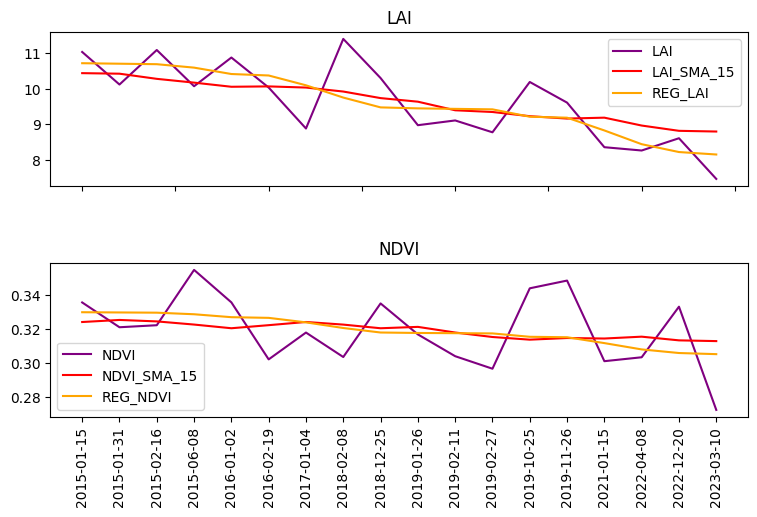

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(9, 5))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

target1 = [axes[0], axes[0], axes[0]]

target2 = [axes[1], axes[1], axes[1]]

axes[0].set_title("LAI");
colors = ['purple', 'red', 'orange']
df[['LAI','LAI_SMA_15', 'REG_LAI']].plot(subplots=True, ax=target1, legend=True, sharex=True, sharey=False, color=colors)

axes[1].set_title("NDVI");
colors = ['purple', 'red', 'orange']
df[['NDVI','NDVI_SMA_15', 'REG_NDVI']].plot(subplots=True, ax=target2, legend=True, sharex=True, sharey=False, color=colors)
plt.xticks(range(0,len(dates)), dates)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees



In [28]:
def pct_change(nparray):
    pct=np.zeros_like(nparray)
    pct[1:]=np.diff(nparray) / np.abs(nparray[:-1])
    #TODO zero divisionerror
    return pct

values = df[['LAI_SMA_15']].to_numpy().flatten().tolist()
np.mean(pct_change(values))

-0.009396179486095122

In [29]:
values = df[['NDVI_SMA_15']].to_numpy().flatten().tolist()
np.mean(pct_change(values))

-0.0019576240766316535